<a href="https://colab.research.google.com/github/Cyusa8/ML-projects/blob/main/Project_priority_level_prediction_with_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#load required modules
#general module
import sys
import io
import zipfile
import requests
from io import BytesIO
#import data module
import numpy as np
import pandas as pd
#import machine learning module
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error, make_scorer
#data visualisation module
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
raw_df = pd.read_csv('/content/drive/MyDrive/large_project_priority_data.csv')
training_df = raw_df[['Estimated Cost (in $)','Community Benefit Score','Stakeholder Engagement Score','Priority Value']]
training_df.index
training_df.head()
print(training_df.info())

#2 Extract features and labels
feature_names = ['Estimated Cost (in $)', 'Community Benefit Score', 'Stakeholder Engagement Score']
label_name = 'Priority Value'



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Estimated Cost (in $)         1000 non-null   int64  
 1   Community Benefit Score       1000 non-null   int64  
 2   Stakeholder Engagement Score  1000 non-null   int64  
 3   Priority Value                1000 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 31.4 KB
None


In [38]:
training_df.describe(include='all')

,Estimated Cost (in $),Community Benefit Score,Stakeholder Engagement Score,Priority Value
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,245679.568000,50.089000,48.44600,49.312828
std,140316.549896,29.309557,29.21761,16.356126
min,10051.000000,0.000000,0.00000,1.949479
25%,122890.250000,24.000000,24.00000,38.457918
50%,242653.000000,51.000000,48.00000,49.711113
75%,368214.250000,75.000000,73.00000,61.126907
max,499910.000000,100.000000,100.00000,95.495823


,Estimated Cost (in $),Community Benefit Score,Stakeholder Engagement Score,Priority Value
Estimated Cost (in $),1.000000,-0.002967,-0.044831,0.488671
Community Benefit Score,-0.002967,1.000000,-0.050878,0.687992
Stakeholder Engagement Score,-0.044831,-0.050878,1.000000,0.476354
Priority Value,0.488671,0.687992,0.476354,1.000000


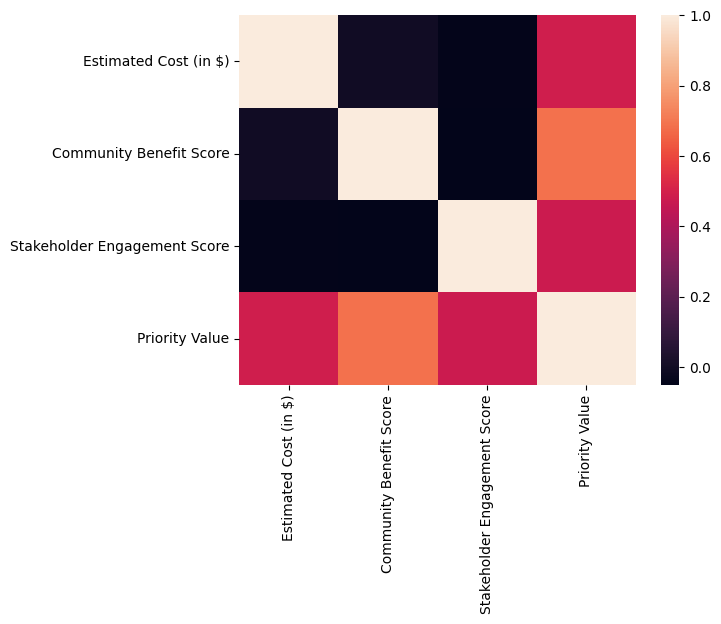

In [51]:
sns.heatmap(training_df.corr())
training_df.corr()

In [79]:
#Build a model function (build and compile a simple linear regression model)
def build_model(learning_rate):
    return make_pipeline(
        StandardScaler(),
        SGDRegressor(
            loss='squared_error',
            penalty=None,
            learning_rate='constant',
            eta0=learning_rate,
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )
    )

''' After  building our model we need to train it by feeding it data '''
#define a function to train the model
def train_model(model, X_train, y_train):
    """
    Fit an sklearn pipeline and return its weights & bias.
    """
    model.fit(X_train, y_train)
    # Extract the underlying SGDRegressor
    sgd = model.named_steps['sgdregressor']
    # coef_ is shape (n_features,), so reshape to (n_features,1)
    weights = sgd.coef_.reshape(-1, 1)
    # intercept_ is shape (1,), so wrap in array
    bias    = np.array([sgd.intercept_[0]])
    return weights, bias

#Define run_experiment function
def run_experiment(df,
                   feature_names,
                   label_name,
                   learning_rate,
                   test_size=0.2,
                   random_state=42):
    # 1) Extract X, y
    X = df[feature_names].values
    y = df[label_name].values

    # 2) Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 3) Build & train
    model   = build_model(learning_rate)                # returns Pipeline(...)
    weights, bias = train_model(model, X_train, y_train)

    # 4) Predict & evaluate
    y_pred = model.predict(X_test)
    rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("📊 Model Evaluation:")
    print(f"✅ RMSE: {rmse:.2f}")
    print(f"✅ MAE: {mae:.2f}")
    print(f"✅ R² Score: {r2:.2f}")

    # 5) Report & plot
    print('\nSUCCESS: Training Experiment Complete\n')
    print(model_info(feature_names, label_name, (weights, bias)))
    model_output = weights, bias, X_test, y_test, y_pred, rmse
    make_plots_sklearn(
        df, feature_names, label_name, model_output
    )

    return model
print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


In [80]:
#@title Define sklearn‑compatible plotting functions
def make_plots_sklearn(df, feature_names, label_name, model_output, sample_size=100):
    """
    Generates two side‑by‑side plots:
      1) Actual vs Predicted (scatter, with RMSE in title)
      2) Model Fit  (scatter + regression line for 1D; optional 3D surface for 2D)

    Args:
      df:             original DataFrame (used only if you want to sample features for plotting)
      feature_names:  list of 1 or 2 feature column names
      label_name:     name of the target column
      model_output:   (weights, bias, X_test, y_test, y_pred, rmse)
      sample_size:    how many test points to plot (for speed)
    """
    weights, bias, X_test, y_test, y_pred, rmse = model_output

    # optionally subsample
    idx = np.random.choice(len(y_test), min(sample_size, len(y_test)), replace=False)
    Xs, ys, ps = X_test[idx], y_test[idx], y_pred[idx]

    is_2d = (len(feature_names) == 1)
    spec2 = "scatter" if is_2d else "surface"

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(
            f"Actual vs Predicted (RMSE={rmse:.3f})",
            "Model Fit"
        ),
        specs=[[{"type":"scatter"}, {"type": spec2}]]
    )

    # 1) Actual vs Predicted
    ap = px.scatter(
        x=ys, y=ps,
        labels={'x':'Actual', 'y':'Predicted'}
    )
    fig.add_trace(ap.data[0], row=1, col=1)
    fig.update_xaxes(title_text="Actual", row=1, col=1)
    fig.update_yaxes(title_text="Predicted", row=1, col=1)

    # 2) Model Fit
    if is_2d:
        # scatter of test points
        sc = px.scatter(
            x=Xs.flatten(), y=ys,
            labels={'x': feature_names[0], 'y': label_name}
        )
        # regression line
        df_line = pd.DataFrame({
            feature_names[0]: X_test.flatten(),
            'pred': y_pred
        })
        ln = px.line(df_line, x=feature_names[0], y='pred')
        fig.add_trace(sc.data[0], row=1, col=2)
        fig.add_trace(ln.data[0], row=1, col=2)
        fig.update_xaxes(title_text=feature_names[0], row=1, col=2)
        fig.update_yaxes(title_text=label_name, row=1, col=2)

    else:
        # 2‑feature case: build a small grid and compute the plane
        f0, f1 = feature_names
        # grid extents
        x0 = np.linspace(X_test[:,0].min(), X_test[:,0].max(), 10)
        x1 = np.linspace(X_test[:,1].min(), X_test[:,1].max(), 10)
        xx0, xx1 = np.meshgrid(x0, x1)
        zz = bias[0] + weights[0][0]*xx0 + weights[1][0]*xx1

        surf = dict(
            type='surface',
            x=xx0, y=xx1, z=zz,
            colorscale='Viridis',
            showscale=False
        )
        fig.add_trace(surf, row=1, col=2)

        # also plot the test points in 3D
        pts = dict(
            type='scatter3d',
            x=Xs[:,0], y=Xs[:,1], z=ys,
            mode='markers',
            marker=dict(size=3, color='red')
        )
        fig.add_trace(pts, row=1, col=2)
        fig.update_scenes(
            dict(
                xaxis_title=f0,
                yaxis_title=f1,
                zaxis_title=label_name
            ),
            row=1, col=2
        )

    fig.show()


def model_info(feature_names, label_name, model_output):
    """
    Generate a formatted string showing each feature weight, the bias,
    and the full linear equation.

    Args:
      feature_names: list of feature column names, e.g. ['Community Benefit Score']
      label_name:    name of the target, e.g. 'Priority Value'
      model_output:  tuple of (weights, bias)
                     - weights: np.array shape (n_features, 1)
                     - bias:    np.array shape (1,)

    Returns:
      A multiline string with a header, each weight, the bias, and the equation.
    """
    weights, bias = model_output

    # Build a nice banner
    nl = "\n"
    header = "-" * 60
    banner = f"{header}{nl}|{'MODEL INFO'.center(58)}|{nl}{header}"

    # List out each weight
    info_lines = []
    equation_terms = []
    for w, feat in zip(weights.flatten(), feature_names):
        info_lines.append(f"Weight for feature [{feat}]: {w:.4f}")
        equation_terms.append(f"{w:.4f}*{feat}")

    # Add bias
    info_lines.append(f"Bias (intercept): {bias[0]:.4f}")
    equation_terms.append(f"{bias[0]:.4f}")

    # Combine into strings
    info_section = nl.join(info_lines)
    equation = f"{label_name} = " + " + ".join(equation_terms)

    return f"{banner}{nl}{info_section}{nl}{nl}{equation}"



In [81]:
# Experiment 1 (sklearn version)

# 1) Hyperparameter
learning_rate = 0.01

# 2) Specify features & label
feature = ['Community Benefit Score','Stakeholder Engagement Score']
label   = 'Priority Value'

# 3) Run experiment
model_1 = run_experiment(
    training_df,
    feature,
    label,
    learning_rate
)


📊 Model Evaluation:
✅ RMSE: 8.48
✅ MAE: 7.35
✅ R² Score: 0.74

SUCCESS: Training Experiment Complete

------------------------------------------------------------
|                        MODEL INFO                        |
------------------------------------------------------------
Weight for feature [Community Benefit Score]: 11.4155
Weight for feature [Stakeholder Engagement Score]: 7.5820
Bias (intercept): 49.7511

Priority Value = 11.4155*Community Benefit Score + 7.5820*Stakeholder Engagement Score + 49.7511


In [82]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create scorers
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)



# Perform 5-fold cross-validation
cv_results = cross_validate(
    model,
    X,
    y,
    cv=5,
    scoring={
        'rmse': rmse_scorer,
        'mae': mae_scorer,
        'r2': r2_scorer
    }
)

    # Show results
print("📊 Cross-Validation Results:")
print("✅ RMSE per fold:", -cv_results['test_rmse'])  # negate since greater_is_better=False
print("✅ MAE per fold:", -cv_results['test_mae'])
print("✅ R² per fold:", cv_results['test_r2'])

print("\n📉 Averages:")
print("Avg RMSE:", -cv_results['test_rmse'].mean())
print("Avg MAE:", -cv_results['test_mae'].mean())
print("Avg R²:", cv_results['test_r2'].mean())


📊 Cross-Validation Results:
✅ RMSE per fold: [8.54908816 8.3118715  8.44054316 8.39496947 8.64563176]
✅ MAE per fold: [7.38381614 7.18943437 7.30689383 7.16989887 7.38129409]
✅ R² per fold: [0.75054432 0.75263297 0.7165269  0.69773158 0.72871704]

📉 Averages:
Avg RMSE: 8.468420811379609
Avg MAE: 7.286267459856222
Avg R²: 0.7292305628786316
